In [ ]:
## Process data with only Tubule cell types

blocklist_file="/clusterfs/nilah/pooja/genomes/hg38.blacklist.rep.bed"
gaps_file="/clusterfs/nilah/pooja/genomes/hg38_gaps.bed"
genome_fasta="/clusterfs/nilah/pooja/genomes/hg38.ml.fa"
genome_sizes="/clusterfs/nilah/pooja/genomes/human.hg38.genome"
out_dir="/clusterfs/nilah/pooja/kidney_data/kidney_sc_data_processed_bigwigs_tubule_cell_types_holdout_chrs"
targets="/clusterfs/nilah/pooja/kidney_data/tubule_targets.txt"

python /global/home/users/poojakathail/basenji/bin/basenji_data.py -b ${blocklist_file} -g ${gaps_file} -p 20 -r 4096 -w 192 -l 1344 -v "chr7,chr14,chr15" -t "chr4,chr5" --stride 192 --stride_test 192 --crop 576 -o ${out_dir} --local ${genome_fasta} ${targets}

In [1]:
%%bash

script_dir="/clusterfs/nilah/pooja/batch_scripts/train"
data_dir="/clusterfs/nilah/pooja/kidney_data/kidney_sc_data_processed_bigwigs_tubule_cell_types_holdout_chrs"
params="/clusterfs/nilah/pooja/kidney_data/models/params_sc_kidney_regression_multitask_tubule_cell_types.json"

cp ${script_dir}/train_immune_atlas_single_task_template.sh ${script_dir}/train_kidney_data_tubule_cell_types.sh
echo "python /global/home/users/poojakathail/basenji/bin/basenji_train.py -k -o /clusterfs/nilah/pooja/kidney_data/train/replicate_models/train__multitask__tubule_cell_types__all_sequences__1/done.txt --float-type float32 ${params} ${data_dir}" >> ${script_dir}/train_kidney_data_tubule_cell_types.sh
sbatch ${script_dir}/train_kidney_data_tubule_cell_types.sh


Submitted batch job 16034313


In [2]:
%%bash

script_dir="/clusterfs/nilah/pooja/batch_scripts/train"

cluster_dir="/clusterfs/nilah/pooja/kidney_data/CellTypeSpecificPeakClusters_ArchR_clust11"
cluster_list="all_sequences,cluster1_CD,cluster2_Immune,cluster3_Ubiquitous,cluster4_DistalNephron,cluster6_PanTubule,cluster7_Tcell,cluster8_PanNonEpithelial,cluster9_Stroma,cluster10_Endothelial,cluster11_PT,cluster12_podocyte"
genome="hg38"
targets="/clusterfs/nilah/pooja/kidney_data/tubule_targets.txt"
model_params="/clusterfs/nilah/pooja/kidney_data/models/params_sc_kidney_regression_multitask_tubule_cell_types.json"
model_dir="/clusterfs/nilah/pooja/kidney_data/train/replicate_models/train__multitask__tubule_cell_types__all_sequences__1"

cp ${script_dir}/train_immune_atlas_single_task_template.sh ${script_dir}/test_kidney_data_multitask_tubule_cell_types.sh
echo "/global/home/users/poojakathail/basenji/bin/basenji_predict_cluster_beds.sh $cluster_dir $cluster_list $genome $targets $model_params ${model_dir}/done.txt ${model_dir}/predict_beds/done_predict_beds.txt" >> ${script_dir}/test_kidney_data_multitask_tubule_cell_types.sh
echo "python /global/home/users/poojakathail/basenji/bin/basenji_reference_accuracy_by_cluster.py -t $targets ${model_dir}/predict_beds/reference_accuracy_by_cluster.tsv ${cluster_dir}/model_predictions" >> ${script_dir}/test_kidney_data_multitask_tubule_cell_types.sh

sbatch ${script_dir}/test_kidney_data_multitask_tubule_cell_types.sh


Submitted batch job 16133840


### Results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.evaluate_basset_performance import *

In [3]:
data_dir = "/clusterfs/nilah/pooja/kidney_data"
fig_dir = "/clusterfs/nilah/pooja/CellTypeSpecificAccessibilityPrediction/figures"

targets = pd.read_csv(f"{data_dir}/targets.txt", sep="\t", header=0, index_col=0)
cell_types = targets["identifier"].values

cell_type_peak_set_mapping = {"PT": ["cluster11_PT", "cluster3_Ubiquitous", "all_sequences"],
                              "DT": ["cluster4_DistalNephron", "cluster3_Ubiquitous", "all_sequences"],
                              "LOH": ["cluster4_DistalNephron", "cluster3_Ubiquitous", "all_sequences"],
                              "Str": ["cluster9_Stroma", "cluster3_Ubiquitous", "all_sequences"],}


tasks = ["single_task", "multitask", "multitask__tubule_cell_types"]
training_sets = ["all_sequences"]

In [4]:
# reference accuracy
ref_acc_by_cluster_replicates = read_reference_accuracy_replicates(data_dir, cell_type_peak_set_mapping.keys(), 
                                                                   tasks, training_sets)
formatted_df = format_df_to_plot(ref_acc_by_cluster_replicates, cell_type_peak_set_mapping,
                                 tasks, training_sets)
formatted_df.loc[~formatted_df["Cluster"].isin(['cluster3_Ubiquitous', 'all_sequences']), 
                 "Cluster"] = "Cell-type specific"


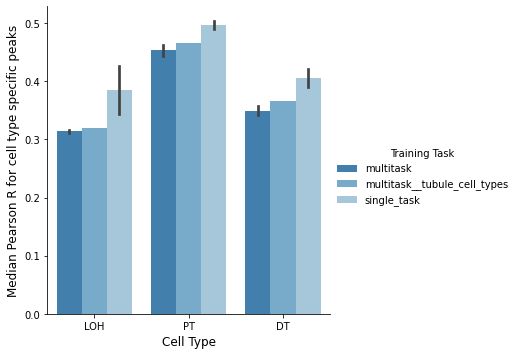

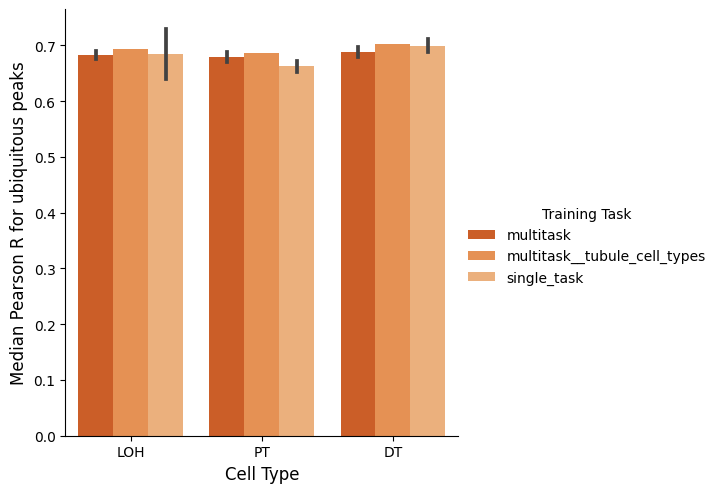

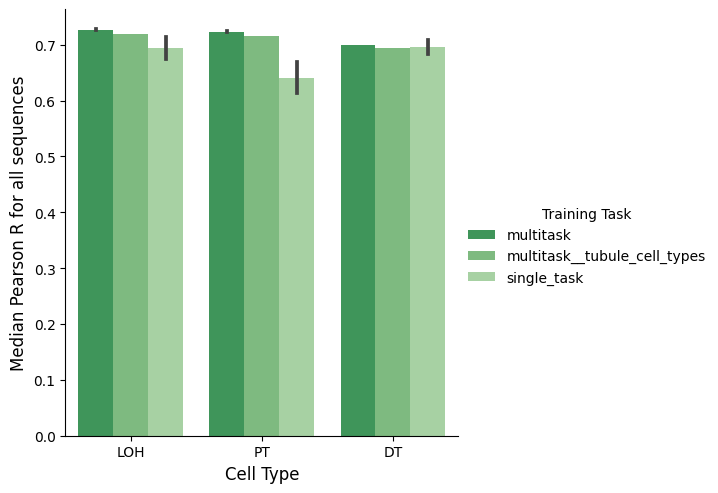

In [5]:
cmap = plt.get_cmap("tab20c")
cluster_labels = ["cell type specific peaks", "ubiquitous peaks", "all sequences"]
for i, cluster in enumerate(["Cell-type specific",  "cluster3_Ubiquitous", "all_sequences"]):
    sns.catplot(data=formatted_df[(formatted_df["Training Data"] == "all_sequences") &
                                  (formatted_df["Cluster"] == cluster)],
                x="Cell Type", y="Pearson R", hue="Training Task", hue_order=["multitask", "multitask__tubule_cell_types", 
                                                                              "single_task"],
                order=["LOH", "PT", "DT"],
                kind="bar", estimator=np.median, ci="sd", palette=[cmap(4*i), cmap(4*i+1), cmap(4*i+2), cmap(4*i+3)],
                legend=True)
    plt.ylabel(f"Median Pearson R for {cluster_labels[i]}" ,fontsize=12)
    plt.xlabel("Cell Type" ,fontsize=12)
    plt.savefig(f"{fig_dir}/supp_figs/loeb_et_al_{cluster}_single_multi_task_tubule_cell_types_barplot_median.pdf", dpi=300)